In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
import pickle
import random
import re
import nltk.stem
from nltk.stem import SnowballStemmer 
from nltk import stem
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve,auc
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns 
from nltk.tokenize import word_tokenize  

In [2]:
main_df = pd.read_csv('airline_sentiment_analysis.csv')
main_df = main_df[['airline_sentiment','text']]
label= main_df['airline_sentiment']
label= list(label)

In [3]:
for i in range(len(label)):
    if label[i] =='positive':
        label[i]= 0
    else:
        label[i]= 1

In [4]:
del(main_df['airline_sentiment'])
main_df['Sentiment']= label

<h1> Data Exploration </h1>

In [5]:
dt= main_df.groupby('Sentiment')
dt.size()

Sentiment
0    2363
1    9178
dtype: int64

c:\users\maniy\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


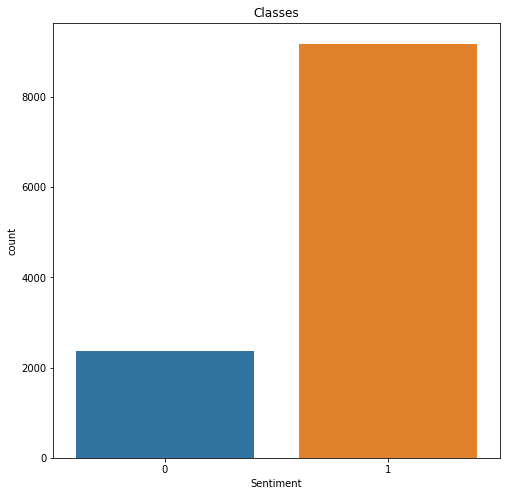

In [6]:
#plotting the dataset
plt.figure(figsize=(8, 8))
sns.countplot('Sentiment', data=main_df)
plt.title('Classes')
plt.show()

<h4>From above figure we can observe that dataset is not so balanced. Though we need not do techniques like undersampling or oversampling in order to make it balanced. It is ok to proceed with this data. We will do balancing techniques if dataset is highly imbalanced i.e ex: 200:1 ratio etc</h4>

In [7]:
main_df['text']

0        @VirginAmerica plus you've added commercials t...
1        @VirginAmerica it's really aggressive to blast...
2        @VirginAmerica and it's a really big bad thing...
3        @VirginAmerica seriously would pay $30 a fligh...
4        @VirginAmerica yes, nearly every time I fly VX...
                               ...                        
11536    @AmericanAir my flight was Cancelled Flightled...
11537           @AmericanAir right on cue with the delays👌
11538    @AmericanAir thank you we got on a different f...
11539    @AmericanAir leaving over 20 minutes Late Flig...
11540    @AmericanAir you have my money, you change my ...
Name: text, Length: 11541, dtype: object

<h4>We can observe that dataset consists of 11540 observations which are reviews(negative or positive) on particular airlines by users</h4></n><h4>Dataset needs to be processed which means, it contains special characters, smileys and alpha numeric values. So dataset needs to be processed for further proceedings of building models and classification</h4>

<h1>Pre-Processing steps</h1>

In [8]:
main_df.isnull().values.any()

False

<h4>There are no null values in our dataset. This is the first and main preprocessing step to check whether there are any null values in our dataset.</h4>

<h2>Levelling case. In this step we will modify all the characters into same case. Generally changed to lowercase.</h2>

In [9]:
main_df['text'] = [entry.lower() for entry in main_df['text']]
main_df

,text,Sentiment
0,@virginamerica plus you've added commercials t...,0
1,@virginamerica it's really aggressive to blast...,1
2,@virginamerica and it's a really big bad thing...,1
3,@virginamerica seriously would pay $30 a fligh...,1
4,"@virginamerica yes, nearly every time i fly vx...",0
...,...,...
11536,@americanair my flight was cancelled flightled...,1
11537,@americanair right on cue with the delays👌,1
11538,@americanair thank you we got on a different f...,0
11539,@americanair leaving over 20 minutes late flig...,1


<h2>Cleaning the text by removing bad symbols and by having only alpha numeric values</h2>

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def Clean_It(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    return text
main_df['text'] = main_df['text'].apply(Clean_It)
main_df

,text,Sentiment
0,virginamerica plus youve added commercials to...,0
1,virginamerica its really aggressive to blast ...,1
2,virginamerica and its a really big bad thing ...,1
3,virginamerica seriously would pay 30 a flight...,1
4,virginamerica yes nearly every time i fly vx...,0
...,...,...
11536,americanair my flight was cancelled flightled...,1
11537,americanair right on cue with the delays,1
11538,americanair thank you we got on a different f...,0
11539,americanair leaving over 20 minutes late flig...,1


<h2>Replacing Contractions</h2>

In [11]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would","youve": "you have", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
main_df['text']= main_df['text'].apply(replace_contractions)
main_df

,text,Sentiment
0,virginamerica plus you have added commercials...,0
1,virginamerica its really aggressive to blast ...,1
2,virginamerica and its a really big bad thing ...,1
3,virginamerica seriously would pay 30 a flight...,1
4,virginamerica yes nearly every time i fly vx...,0
...,...,...
11536,americanair my flight was cancelled flightled...,1
11537,americanair right on cue with the delays,1
11538,americanair thank you we got on a different f...,0
11539,americanair leaving over 20 minutes late flig...,1


<h4>One Small observation is that after replacing contractions, in 0th observation, youve has changed to you have which is now equivalent to 11540th observation. This step is important because we want all the wordings to be similar for further comparision and processing</h4>

<h1>Normalization and Tokenization</h1>

<h3>In this step different forms of words like organize, organizes and organizing are identified as a single word organize. Words of different character sequence is chopped into tokens which is called tokenization.</h3>

In [12]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
main_df['text']= main_df['text'].apply(lemmatize_stemming)
main_df['text']

0         virginamerica plus you have added commercials...
1         virginamerica its really aggressive to blast ...
2         virginamerica and its a really big bad thing ...
3         virginamerica seriously would pay 30 a flight...
4         virginamerica yes  nearly every time i fly vx...
                               ...                        
11536     americanair my flight was cancelled flightled...
11537              americanair right on cue with the delay
11538     americanair thank you we got on a different f...
11539     americanair leaving over 20 minutes late flig...
11540     americanair you have my money  you change my ...
Name: text, Length: 11541, dtype: object

In [13]:
main_df['text'][0]

' virginamerica plus you have added commercials to the experience tacki'

<h1>Removing Stopwords</h1>
<h3>Stop words are vast in number and they don't help us find the context or the true meaning of a sentence. These are words that can be removed without any negative consequences. So by removing stop words it boosts training speed.</h3>

In [14]:
Normalized_Reviews=[]
for i in range(len(main_df['text'])):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(main_df['text'][i])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    filtered_sentence = []
    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(w)
    Normalized_Reviews.append(filtered_sentence)
Normalized_Reviews= pd.Series(Normalized_Reviews)
type(Normalized_Reviews)

pandas.core.series.Series

<h1>Saving the preprocessed data</h1><h3>We will save this data for further analysis of our models because this preprocessing may take time for different processors. By saving as csv, Next step while we are building models, we need not do preprocessing again from scratch, we just need to load the csv.</h3>

In [15]:
main_df['text']= Normalized_Reviews
main_df.to_csv('Normalized_Airlines.csv',index= False)

<h1>Creating models for prediction and evaluation of model</h1>

In [16]:
main_df= pd.read_csv('Normalized_Airlines.csv')

In [17]:
##Splitting the data into training and testing
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(main_df['text'],main_df['Sentiment'],test_size=0.3)

In [18]:
type(Normalized_Reviews)

pandas.core.series.Series

In [19]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(main_df['text'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
#print(Tfidf_vect.vocabulary_)

In [20]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions = Naive.predict(Test_X_Tfidf)

In [21]:
print("Training Accuracy: ",Naive.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",Naive.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.8927952463481059
Test Accuracy:  0.8746751371643084


In [22]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       0.97      0.39      0.55       694
           1       0.87      1.00      0.93      2769

    accuracy                           0.87      3463
   macro avg       0.92      0.69      0.74      3463
weighted avg       0.89      0.87      0.85      3463



In [23]:
from sklearn.svm import LinearSVC
SVM = LinearSVC()
SVM.fit(Train_X_Tfidf,Train_Y)
predictions = SVM.predict(Test_X_Tfidf)

In [24]:
print("Training Accuracy: ",Naive.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",Naive.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.8927952463481059
Test Accuracy:  0.8746751371643084


In [25]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       694
           1       0.93      0.97      0.95      2769

    accuracy                           0.91      3463
   macro avg       0.89      0.84      0.86      3463
weighted avg       0.91      0.91      0.91      3463



In [32]:
from sklearn.neighbors import KNeighborsClassifier
Knn = KNeighborsClassifier()
Knn.fit(Train_X_Tfidf,Train_Y)
predictions = Knn.predict(Test_X_Tfidf)
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [27]:
print("Training Accuracy: ",Knn.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",Knn.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.9196583312701163
Test Accuracy:  0.8654345942824141


In [28]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       694
           1       0.93      0.90      0.91      2769

    accuracy                           0.87      3463
   macro avg       0.79      0.81      0.80      3463
weighted avg       0.87      0.87      0.87      3463



In [29]:
RF=RandomForestClassifier(n_estimators=100,min_samples_split=25,max_depth=10)
RF = RF.fit(Train_X_Tfidf,Train_Y)
predictions = RF.predict(Test_X_Tfidf)

In [30]:
print("Training Accuracy: ",RF.score(Train_X_Tfidf,Train_Y))
print("Test Accuracy: ",RF.score(Test_X_Tfidf,Test_Y))

Training Accuracy:  0.7937608318890814
Test Accuracy:  0.8001732601790356


In [31]:
print(classification_report(Test_Y,predictions))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       694
           1       0.80      1.00      0.89      2769

    accuracy                           0.80      3463
   macro avg       0.90      0.50      0.45      3463
weighted avg       0.84      0.80      0.71      3463

